# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = 'tripdata_ACSData_2023-09.csv'
df = pd.read_csv(file_path)

In [ ]:
print(" Dataset shape (rows, columns):", df.shape)

print("\n Columns:")
print(df.columns.tolist())

print("\n Data types:")
print(df.dtypes)

print("\n Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

In [ ]:
print(df.iloc[0].to_string())

In [ ]:
df_clean = df.dropna(subset=['pickup_zipcode', 'dropoff_zipcode', 'zipcode'])
print(f"Rows after dropping null zipcodes: {len(df_clean):,}")
initial_rows = len(df)
dropped_rows = initial_rows - len(df_clean)
print(f"Dropped rows with missing zipcodes: {dropped_rows:,}")

In [ ]:
negative_fares = df_clean[df_clean['base_passenger_fare'] < 0]
print(f"Number of trips with negative base fare: {len(negative_fares):,}")

In [ ]:
# remove the negative base fare rows
df_clean = df_clean[df_clean['base_passenger_fare'] >= 0]
print(f"Rows after dropping negative base fare: {len(df_clean):,}")

In [ ]:
df_clean.to_csv('cleaned_tripdata_ACSData_2023-09.csv', index=False)

In [2]:
import gc
gc.collect()

0

In [4]:
# Only read the columns you need
columns_needed = [
    'dropoff_zipcode',
    'Households!!Median income (dollars)',
    'Percent below poverty level!!Population for whom poverty status is determined',
    'RACE!!Total population!!One race!!White',
    'RACE!!Total population!!One race!!Black or African American',
    'RACE!!Total population!!One race!!Asian',
    'RACE!!Total population!!One race!!Some Other Race',
    'Total population',
    'trip_miles',
    'trip_time',
    'shared_request_flag',
    'base_passenger_fare'
]

# Read only selected columns from CSV
df_clean = pd.read_csv('cleaned_tripdata_ACSData_2023-09.csv', usecols=columns_needed)

In [5]:
# Safe type conversion
df_clean['dropoff_zipcode'] = df_clean['dropoff_zipcode'].astype('Int64')

# Save smaller feather file
df_clean.to_feather('df_clean.feather')

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------
# Step 1: Read and Select Important Columns
# ----------------------------------------

# Read the full cleaned dataset
df_clean = pd.read_feather("df_clean.feather")
df_demo = df_clean[columns_needed].copy()

# ----------------------------------------
# Step 2: Convert Columns to Numeric Safely
# ----------------------------------------

# Some demographic fields need type conversion
numeric_cols = [
    'Households!!Median income (dollars)',
    'Percent below poverty level!!Population for whom poverty status is determined',
    'Total population'
]

for col in numeric_cols:
    df_demo[col] = pd.to_numeric(df_demo[col], errors='coerce')

# Drop rows missing key demographic values
df_demo.dropna(subset=numeric_cols, inplace=True)

# Save small cleaned file (optional, for future)
df_demo.to_feather("df_demo.feather")

# ----------------------------------------
# Step 3: Race Group Assignment
# ----------------------------------------

# Race group by highest proportion
race_cols = {
    'White': 'RACE!!Total population!!One race!!White',
    'Black': 'RACE!!Total population!!One race!!Black or African American',
    'Asian': 'RACE!!Total population!!One race!!Asian',
    'Other': 'RACE!!Total population!!One race!!Some Other Race'
}

def assign_race_group(row):
    race_counts = {race: row[col] for race, col in race_cols.items()}
    return max(race_counts, key=race_counts.get)

df_demo['race_group'] = df_demo.apply(assign_race_group, axis=1)

# ----------------------------------------
# Step 4: Create fare_level (Binary Label)
# ----------------------------------------

median_fare = df_demo['base_passenger_fare'].median()
df_demo['fare_level'] = (df_demo['base_passenger_fare'] > median_fare).astype(int)

# Convert shared_request_flag to binary (Y=1, N=0)
df_demo['shared_flag_binary'] = df_demo['shared_request_flag'].map({'Y': 1, 'N': 0})


In [11]:
from tabulate import tabulate  # pip install tabulate if needed

# 1. Group and aggregate
trip_features = df_demo.groupby('race_group').agg(
    total_rides=('trip_miles', 'count'),   # Count total number of trips
    avg_trip_miles=('trip_miles', 'mean'),
    avg_trip_time_sec=('trip_time', 'mean'),
    shared_ride_rate=('shared_flag_binary', 'mean')
).reset_index()

# 2. Convert trip time from seconds to minutes
trip_features['avg_trip_time_min'] = trip_features['avg_trip_time_sec'] / 60

# 3. Keep and rename columns clearly
trip_features = trip_features[['race_group', 'total_rides', 'avg_trip_miles', 'avg_trip_time_min', 'shared_ride_rate']]
trip_features = trip_features.rename(columns={
    'total_rides': 'Total Rides',
    'avg_trip_miles': 'Avg Trip Miles (miles)',
    'avg_trip_time_min': 'Avg Trip Time (minutes)',
    'shared_ride_rate': 'Shared Ride Rate (%)'
})

# 4. Format shared ride rate as percentage
trip_features['Shared Ride Rate (%)'] = trip_features['Shared Ride Rate (%)'] * 100

# 5. Round nicely
trip_features = trip_features.round(2)

# 6. Print clean markdown table
print(tabulate(trip_features, headers='keys', tablefmt='github'))


|    | race_group   |   Total Rides |   Avg Trip Miles (miles) |   Avg Trip Time (minutes) |   Shared Ride Rate (%) |
|----|--------------|---------------|--------------------------|---------------------------|------------------------|
|  0 | Asian        |       1129633 |                     4.4  |                     18.02 |                   3.32 |
|  1 | Black        |       4487052 |                     4.12 |                     18.34 |                   4.02 |
|  2 | Other        |       1690473 |                     4.28 |                     17.4  |                   3.24 |
|  3 | White        |      10296012 |                     4.08 |                     19.95 |                   2.55 |


In [ ]:
# ----------------------------------------
# (Optional) Step 6: Bar Chart for High Fare Rate
# ----------------------------------------

high_fare_rate = df_demo.groupby('race_group')['fare_level'].mean().reset_index()

# Use a visually distinct color palette
plt.figure(figsize=(8, 5))
sns.barplot(data=high_fare_rate, x='race_group', y='fare_level', palette='pastel')

# Updated title to reflect it's about BASE fare
plt.title('Proportion of High Base Fare Rides by Race Group', fontsize=14)
plt.ylabel('Share of High Fare Rides (fare_level = 1)')
plt.xlabel('Race Group (Based on Dropoff Zipcode)')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [12]:
from scipy.stats import chi2_contingency
import pandas as pd

# Build contingency table
contingency_table = pd.crosstab(df_demo['race_group'], df_demo['fare_level'])

# Run Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi2 statistic: 401611.19, p-value: 0.0000


C:\Users\Dell\AppData\Local\Temp\ipykernel_6872\2265902632.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_demo, x='race_group', y='base_passenger_fare', palette='pastel')
C:\Users\Dell\AppData\Local\Temp\ipykernel_6872\2265902632.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 50)


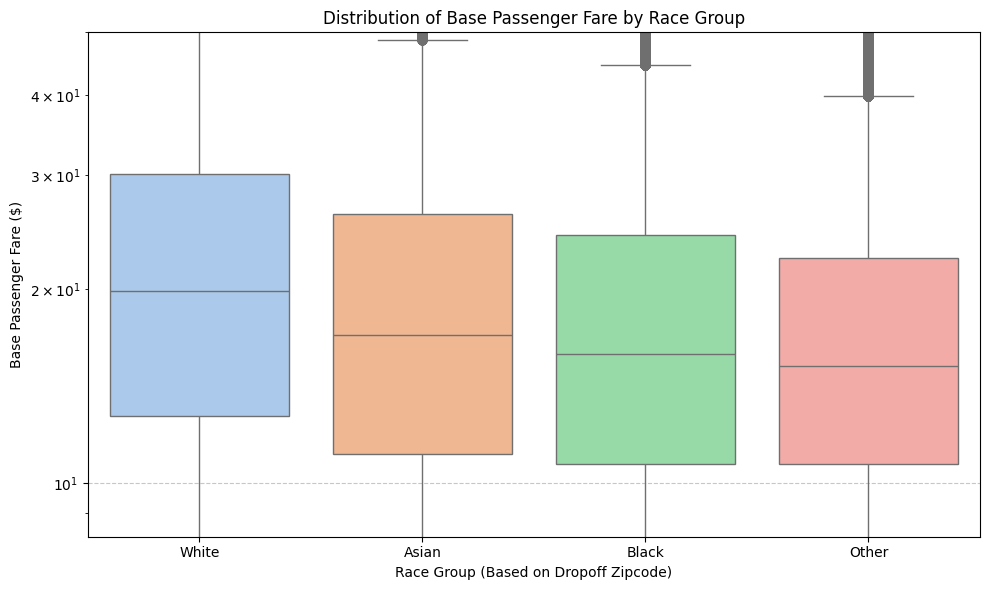

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

# Assume df_demo already prepared and has 'race_group' and 'base_passenger_fare'

# ----------------------------------------
# Step 1: Boxplot of Base Fare Amounts
# ----------------------------------------

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_demo, x='race_group', y='base_passenger_fare', palette='pastel')
plt.yscale('log')  # Optional: use log scale to handle large outliers
plt.title('Distribution of Base Passenger Fare by Race Group')
plt.ylabel('Base Passenger Fare ($)')
plt.xlabel('Race Group (Based on Dropoff Zipcode)')
plt.ylim(0, 50)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:

# ----------------------------------------
# Step 2: ANOVA Test for Base Fare Differences
# ----------------------------------------

# Separate base fares by race group
asian_fares = df_demo[df_demo['race_group'] == 'Asian']['base_passenger_fare']
black_fares = df_demo[df_demo['race_group'] == 'Black']['base_passenger_fare']
white_fares = df_demo[df_demo['race_group'] == 'White']['base_passenger_fare']
other_fares = df_demo[df_demo['race_group'] == 'Other']['base_passenger_fare']

# Run one-way ANOVA
anova_result = f_oneway(asian_fares, black_fares, white_fares, other_fares)

print(f"ANOVA F-statistic: {anova_result.statistic:.2f}")
print(f"ANOVA p-value: {anova_result.pvalue:.4f}")


ANOVA F-statistic: 101356.44
ANOVA p-value: 0.0000


# Company-Level Overview

In [ ]:
print("Unique HVFHS license numbers in cleaned data:")
print(df_clean['hvfhs_license_num'].unique())

In [ ]:
# Map license numbers to company names
company_map = {
    'HV0002': 'Juno',
    'HV0003': 'Uber',
    'HV0004': 'Via',
    'HV0005': 'Lyft'
}
df_clean.loc[:, 'company'] = df_clean['hvfhs_license_num'].map(company_map)

# Group by company
company_summary = df_clean.groupby('company').agg(
    num_trips=('hvfhs_license_num', 'count'),
    total_fare=('base_passenger_fare', 'sum'),
    avg_fare=('base_passenger_fare', 'mean')
).reset_index()

# Add percentage of total trips
total_trips = company_summary['num_trips'].sum()
company_summary['trip_share_%'] = round(company_summary['num_trips'] / total_trips * 100, 2)

# Display summary
print("Company-Level Summary:")
print(company_summary)

In [ ]:
# Boxplot: Fare distribution by company
plt.figure(figsize=(10, 5))
sns.boxplot(x='company', y='base_passenger_fare', data=df_clean[df_clean['base_passenger_fare'] < 100])  # remove extreme outliers
plt.title("Fare Distribution by Company (base_passenger_fare < $100)")
plt.ylabel("Base Fare ($)")
plt.xlabel("Company")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Ride-Type Breakdown

```
shared_request_flag: Did the passenger agree to a shared/pooled ride, regardless of whether they were matched? (Y/N) 
shared_match_flag: Did the passenger share the vehicle with another passenger who booked separately at any point during the trip? (Y/N)
wav_request_flag: Did the passenger request a wheelchair-accessible vehicle (WAV)? (Y/N) 
wav_match_flag: Did the trip occur in a wheelchair-accessible vehicle (WAV)? (Y/N)
```

In [ ]:
# Set float display format
pd.options.display.float_format = '{:,.2f}'.format

# Shared ride request flag summary
shared_summary = df_clean['shared_request_flag'].value_counts(dropna=False).rename_axis('shared_request_flag').reset_index(name='count')
shared_summary['percentage'] = (shared_summary['count'] / len(df_clean) * 100).round(2)
print("Shared Request Flag Summary:")
print(shared_summary)

# Shared ride match flag summary
match_summary = df_clean['shared_match_flag'].value_counts(dropna=False).rename_axis('shared_match_flag').reset_index(name='count')
match_summary['percentage'] = (match_summary['count'] / len(df_clean) * 100).round(2)
print("\nShared Match Flag Summary:")
print(match_summary)

# Average fare by shared request status
print("\nAverage Base Fare by Shared Request Flag:")
print(df_clean.groupby('shared_request_flag')['base_passenger_fare'].mean())

In [ ]:
# WAV request flag summary
wav_request_summary = df_clean['wav_request_flag'].value_counts(dropna=False).rename_axis('wav_request_flag').reset_index(name='count')
wav_request_summary['percentage'] = (wav_request_summary['count'] / len(df_clean) * 100).round(2)
print("\nWAV Request Flag Summary:")
print(wav_request_summary)

# WAV match flag summary
wav_match_summary = df_clean['wav_match_flag'].value_counts(dropna=False).rename_axis('wav_match_flag').reset_index(name='count')
wav_match_summary['percentage'] = (wav_match_summary['count'] / len(df_clean) * 100).round(2)
print("\nWAV Match Flag Summary:")
print(wav_match_summary)

In [ ]:
# Categorize ride type for comparison
def label_ride_type(row):
    if row['access_a_ride_flag'] == 'Y':
        return 'Accessible'
    elif row['shared_request_flag'] == 'Y':
        return 'Shared'
    else:
        return 'Regular'

df_clean['ride_type'] = df_clean.apply(label_ride_type, axis=1)

# Calculate average toll per ride type
toll_comparison = df_clean.groupby('ride_type')['tolls'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(toll_comparison['ride_type'], toll_comparison['tolls'], color=['#3182bd', '#9ecae1', '#fdae6b'])
plt.title("Average Tolls by Ride Type")
plt.xlabel("Ride Type")
plt.ylabel("Average Toll ($)")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Geographic Patterns

In [ ]:
Median fare, min/max fare, avg fare by dropoff_zipcode

Trip count heatmap by zipcode

Distance vs. fare across different areas

Are certain zip codes always paying more per mile?

In [ ]:
print("Number of unique dropoff zipcodes:", df_clean['dropoff_zipcode'].nunique())
print("Number of unique pickup zipcodes:", df_clean['pickup_zipcode'].nunique())

In [ ]:
# Group by dropoff_zipcode
df_clean = pd.read_feather("df_clean.feather")


# Basic zipcode-level aggregation
zipcode_stats = df_clean.groupby('dropoff_zipcode').agg(
    trip_count=('base_passenger_fare', 'count'),
    median_fare=('base_passenger_fare', 'median'),
    avg_fare=('base_passenger_fare', 'mean'),
    std_fare=('base_passenger_fare', 'std'),
    min_fare=('base_passenger_fare', 'min'),
    max_fare=('base_passenger_fare', 'max'),
    avg_miles=('trip_miles', 'mean'),
    avg_fare_per_mile=('base_passenger_fare', lambda x: x.sum() / df_clean.loc[x.index, 'trip_miles'].sum())
).reset_index()

# Coefficient of variation (std / mean)
zipcode_stats['fare_cv'] = zipcode_stats['std_fare'] / zipcode_stats['avg_fare']

# Interquartile range (IQR)
q1 = df_clean.groupby('dropoff_zipcode')['base_passenger_fare'].quantile(0.25)
q3 = df_clean.groupby('dropoff_zipcode')['base_passenger_fare'].quantile(0.75)
iqr = (q3 - q1).rename('fare_iqr')
zipcode_stats = zipcode_stats.merge(iqr, on='dropoff_zipcode', how='left')

# Count of expensive trips (> $100) Flags unusual high-fare density
expensive_counts = df_clean[df_clean['base_passenger_fare'] > 100].groupby('dropoff_zipcode').size()
zipcode_stats['num_expensive'] = zipcode_stats['dropoff_zipcode'].map(expensive_counts).fillna(0).astype(int)

# % of short trips (< 1 mile) Helps detect if short rides are overcharged in some areas
short_counts = df_clean[df_clean['trip_miles'] < 1].groupby('dropoff_zipcode').size()
zipcode_stats['pct_short_trips'] = (short_counts / zipcode_stats['trip_count']).fillna(0) * 100
# View top rows
print(zipcode_stats.head())

In [ ]:
# Top 10 by average fare
top10_avg = zipcode_stats.sort_values('avg_fare', ascending=False).head(10)
print("Top 10 Zipcodes by Average Fare:")
print(top10_avg[['dropoff_zipcode', 'avg_fare', 'trip_count']])
print("\n" + "="*60 + "\n")

# Bottom 10 by average fare
bottom10_avg = zipcode_stats.sort_values('avg_fare', ascending=True).head(10)
print("Bottom 10 Zipcodes by Average Fare:")
print(bottom10_avg[['dropoff_zipcode', 'avg_fare', 'trip_count']])
print("\n" + "="*60 + "\n")

# Top 10 by fare per mile
top10_ppm = zipcode_stats.sort_values('avg_fare_per_mile', ascending=False).head(10)
print("Top 10 Zipcodes by Average Fare per Mile:")
print(top10_ppm[['dropoff_zipcode', 'avg_fare_per_mile', 'avg_miles', 'trip_count']])
print("\n" + "="*60 + "\n")

# Top 10 most variable fares (by std deviation)
top10_variable = zipcode_stats.sort_values('std_fare', ascending=False).head(10)
print("Top 10 Zipcodes by Fare Variability (Std Dev):")
print(top10_variable[['dropoff_zipcode', 'std_fare', 'avg_fare', 'trip_count']])

In [ ]:
def annotated_barplot(data, x, y, title, ylabel):
    # Sort by y to control bar order (left to right)
    data_sorted = data.sort_values(by=y, ascending=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=data_sorted,
        x=x,
        y=y,
        palette='viridis',
        order=data_sorted[x]  # ensure left-to-right ordering
    )
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Zipcode")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, data_sorted[y].max() * 1.2)

    # Add real value labels on top
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Create all 4 annotated plots
annotated_barplot(top10_avg, 'dropoff_zipcode', 'avg_fare', "Top 10 Zipcodes by Average Fare", "Average Fare ($)")
annotated_barplot(bottom10_avg, 'dropoff_zipcode', 'avg_fare', "Bottom 10 Zipcodes by Average Fare", "Average Fare ($)")
annotated_barplot(top10_ppm, 'dropoff_zipcode', 'avg_fare_per_mile', "Top 10 Zipcodes by Fare per Mile", "Fare per Mile ($)")
annotated_barplot(top10_variable, 'dropoff_zipcode', 'std_fare', "Top 10 Zipcodes by Fare Variability (Std Dev)", "Std Deviation ($)")

In [ ]:
# Heatmap of trip counts by zipcode
top_zipcodes['dropoff_zipcode'] = top_zipcodes['dropoff_zipcode'].astype(str)
plt.figure(figsize=(14, 5))
sns.barplot(data=top_zipcodes, x='dropoff_zipcode', y='trip_count', palette='Blues_d')
plt.title("Top 30 Dropoff Zipcodes by Trip Count")
plt.xlabel("Dropoff Zipcode")
plt.ylabel("Trip Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

# Filter data: only keep trips with miles between 0 and 50 and positive fare
sample = df_clean[
    (df_clean['trip_miles'] > 0) &
    (df_clean['trip_miles'] <= 50) &
    (df_clean['base_passenger_fare'] > 0)
].sample(100000, random_state=1)

# Scatter plot
sns.scatterplot(data=sample, x='trip_miles', y='base_passenger_fare', alpha=0.2)

# Add regression line
sns.regplot(
    data=sample,
    x='trip_miles',
    y='base_passenger_fare',
    scatter=False,               
    line_kws={'color': 'red'}
)

plt.title("Trip Miles vs. Base Fare with Regression Line (Sample, Trips ≤ 50 Miles)")
plt.xlabel("Trip Miles")
plt.ylabel("Base Fare ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))

# Filter: trip_time > 0 and ≤ 3600 seconds (1 hour), positive fare
sample = df_clean[
    (df_clean['trip_time'] > 0) &
    (df_clean['trip_time'] <= 3600) &
    (df_clean['base_passenger_fare'] > 0)
].sample(100000, random_state=1)

# Plot with regression line
sns.regplot(
    data=sample,
    x='trip_time',
    y='base_passenger_fare',
    scatter_kws={'alpha': 0.2},  # transparency of scatter points
    line_kws={'color': 'red'}    # regression line styling
)

plt.title("Trip Time vs. Base Fare with Regression Line (Sample, Trips ≤ 1 Hour)")
plt.xlabel("Trip Time (seconds)")
plt.ylabel("Base Fare ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Demographics & Bias Indicators

In [ ]:
# Read the full cleaned dataset
df_clean = pd.read_feather("df_clean.feather")

# Select only relevant demographic and fare columns
columns_needed = [
    'dropoff_zipcode',
    'Households!!Median income (dollars)',
    'Percent below poverty level!!Population for whom poverty status is determined',
    'RACE!!Total population!!One race!!White',
    'RACE!!Total population!!One race!!Black or African American',
    'RACE!!Total population!!One race!!Asian',
    'RACE!!Total population!!One race!!Some Other Race',
    'Total population',
    'base_passenger_fare',
    'tolls'
]

df_demo = df_clean[columns_needed].copy()

# Convert critical columns to numeric safely
numeric_cols = [
    'Households!!Median income (dollars)',
    'Percent below poverty level!!Population for whom poverty status is determined',
    'Total population'
]

for col in numeric_cols:
    df_demo[col] = pd.to_numeric(df_demo[col], errors='coerce')

# Drop rows with any missing key demographic values
df_demo.dropna(subset=numeric_cols, inplace=True)

# Save cleaned subset
df_demo.to_feather("df_demo.feather")


In [ ]:
# Read cleaned feather
df_demo = pd.read_feather("df_demo.feather")

# Group by zipcode and aggregate demographics
demographic_summary = df_demo.groupby('dropoff_zipcode').agg(
    median_income=('Households!!Median income (dollars)', 'mean'),
    poverty_rate=('Percent below poverty level!!Population for whom poverty status is determined', 'mean'),
    avg_fare=('base_passenger_fare', 'mean'),
    white=('RACE!!Total population!!One race!!White', 'sum'),
    black=('RACE!!Total population!!One race!!Black or African American', 'sum'),
    asian=('RACE!!Total population!!One race!!Asian', 'sum'),
    other=('RACE!!Total population!!One race!!Some Other Race', 'sum'),
    total_population=('Total population', 'sum')
).reset_index()

# Compute racial percentages properly
demographic_summary['white_pct'] = demographic_summary['white'] / demographic_summary['total_population']
demographic_summary['black_pct'] = demographic_summary['black'] / demographic_summary['total_population']
demographic_summary['asian_pct'] = demographic_summary['asian'] / demographic_summary['total_population']
demographic_summary['other_pct'] = demographic_summary['other'] / demographic_summary['total_population']

# Bin zipcodes into income deciles
demographic_summary['income_decile'] = pd.qcut(demographic_summary['median_income'], 10, labels=False)
income_bins = pd.qcut(demographic_summary['median_income'], 10)
demographic_summary['income_decile_label'] = income_bins

# Compare avg fare by income decile
income_decile_fares = demographic_summary.groupby('income_decile')['avg_fare'].mean().reset_index()


In [ ]:
# Scatter: Poverty Rate vs. Avg Fare
plt.figure(figsize=(7, 5))
sns.scatterplot(data=demographic_summary, x='poverty_rate', y='avg_fare')
plt.title("Avg Fare vs. Poverty Rate by Zipcode")
plt.xlabel("Poverty Rate (%)")
plt.ylabel("Average Fare ($)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# Line Plot: Income Decile vs. Avg Fare
demographic_summary['income_decile_label'] = demographic_summary['income_decile_label'].astype(str)

plt.figure(figsize=(10, 5))
sns.lineplot(data=demographic_summary, x='income_decile_label', y='avg_fare', marker='o')
plt.title("Average Fare by Median Income Decile")
plt.xlabel("Income Range (Decile Labels)")
plt.ylabel("Average Fare ($)")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# Top 10 by fare
top_zip = demographic_summary.sort_values('avg_fare', ascending=False).head(10)

# Bottom 10 by fare
bottom_zips = demographic_summary.sort_values('avg_fare', ascending=True).head(10)

# Melt for grouped barplot
top_melted = top_zip.melt(id_vars='dropoff_zipcode', value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
                          var_name='Race', value_name='Proportion')
bottom_melted = bottom_zips.melt(id_vars='dropoff_zipcode', value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
                                 var_name='Race', value_name='Proportion')

# Barplot for top 10 (avg across them)
avg_top = top_melted.groupby('Race')['Proportion'].mean().reset_index()
plt.figure(figsize=(7, 5))
sns.barplot(data=avg_top, x='Race', y='Proportion', palette='pastel')
plt.title("Average Race Distribution in 10 Highest Fare Zipcodes")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Barplot for bottom 10 (avg across them)
avg_bottom = bottom_melted.groupby('Race')['Proportion'].mean().reset_index()
plt.figure(figsize=(7, 5))
sns.barplot(data=avg_bottom, x='Race', y='Proportion', palette='muted')
plt.title("Average Race Distribution in 10 Lowest Fare Zipcodes")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Prepare top 10 by fare
top_zip = demographic_summary.sort_values('avg_fare', ascending=False).head(10).copy()
top_zip['Rank'] = range(1, 11)
top_melted = top_zip.melt(
    id_vars=['dropoff_zipcode', 'Rank', 'avg_fare'],
    value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
    var_name='Race',
    value_name='Proportion'
)

# Plot: Grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_melted, x='dropoff_zipcode', y='Proportion', hue='Race')
plt.title("Race Distribution in 10 Highest Fare Zipcodes")
plt.ylim(-0.08, 1.05)
plt.xlabel("Dropoff Zipcode")
plt.ylabel("Proportion")
plt.xticks(rotation=45)

# Add rank + avg fare annotation BELOW each group
for i, (zipcode, rank, fare) in enumerate(zip(top_zip['dropoff_zipcode'], top_zip['Rank'], top_zip['avg_fare'])):
    plt.text(i, -0.05, f"#{rank} (${fare:.2f})", ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()


In [ ]:
# Prepare bottom 10 by fare
bottom_zip = demographic_summary.sort_values('avg_fare', ascending=True).head(10).copy()
bottom_zip['Rank'] = range(1, 11)
bottom_melted = bottom_zip.melt(
    id_vars=['dropoff_zipcode', 'Rank', 'avg_fare'],
    value_vars=['white_pct', 'black_pct', 'asian_pct', 'other_pct'],
    var_name='Race',
    value_name='Proportion'
)

# Plot: Grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=bottom_melted, x='dropoff_zipcode', y='Proportion', hue='Race')
plt.title("Race Distribution in 10 Lowest Fare Zipcodes")
plt.ylim(-0.08, 1.05)
plt.xlabel("Dropoff Zipcode")
plt.ylabel("Proportion")
plt.xticks(rotation=45)

# Add rank + avg fare annotation BELOW each group
x_labels = [tick.get_text() for tick in ax.get_xticklabels()]
for i, (zipcode, rank, fare) in enumerate(zip(bottom_zip['dropoff_zipcode'], bottom_zip['Rank'], bottom_zip['avg_fare'])):
    plt.text(i, -0.05, f"#{rank} (${fare:.2f})", ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()


In [ ]:
# Load the cleaned demographic dataset
df_demo = pd.read_feather("df_demo.feather")

# Bin percent poverty into 5 levels
df_demo['poverty_bin'] = pd.qcut(
    df_demo['Percent below poverty level!!Population for whom poverty status is determined'],
    q=5,
    labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
)

# Bin white_pct into 5 levels
df_demo['white_pct'] = df_demo['RACE!!Total population!!One race!!White'] / df_demo['Total population']
df_demo['white_bin'] = pd.qcut(df_demo['white_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Bin black_pct into 5 levels
df_demo['black_pct'] = df_demo['RACE!!Total population!!One race!!Black or African American'] / df_demo['Total population']
df_demo['black_bin'] = pd.qcut(df_demo['black_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Bin Asian population share
df_demo['asian_pct'] = df_demo['RACE!!Total population!!One race!!Asian'] / df_demo['Total population']
df_demo['asian_bin'] = pd.qcut(df_demo['asian_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Bin Other race population share
df_demo['other_pct'] = df_demo['RACE!!Total population!!One race!!Some Other Race'] / df_demo['Total population']
df_demo['other_bin'] = pd.qcut(df_demo['other_pct'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])


In [ ]:
# Group by poverty_bin
poverty_summary = df_demo.groupby('poverty_bin').agg(
    avg_fare=('base_passenger_fare', 'mean')
).reset_index()

# Plot: Fare by Poverty Bin
plt.figure(figsize=(8, 5))
sns.barplot(data=poverty_summary, x='poverty_bin', y='avg_fare', palette='Blues')
plt.title("Average Fare by Poverty Level")
plt.xlabel("Poverty Level")
plt.ylabel("Average Fare ($)")
plt.tight_layout()
plt.show()


In [ ]:
# Plot with FacetGrid
g = sns.FacetGrid(summary, col='Race', sharey=True, col_order=['White', 'Black', 'Asian', 'Other'])
g.map_dataframe(sns.barplot, x='RaceBin', y='avg_fare', palette='viridis')

# Tweak labels
g.set_axis_labels("", "Avg Fare ($)")  # <- This line removes the shared x-axis label
g.set_titles("{col_name} Population")

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd

# Load NYC zip code shapefile or GeoJSON
nyc_zip_shapefile = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")  # or .shp
nyc_zip_shapefile['dropoff_zipcode'] = nyc_zip_shapefile['postalCode'].astype(float)  # match dtype

# Merge with your demographic_summary
gdf = nyc_zip_shapefile.merge(demographic_summary, on='dropoff_zipcode', how='left')


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='avg_fare', ax=ax, legend=True, cmap='OrRd', edgecolor='black')
ax.set_title("Average Fare by Dropoff Zipcode (NYC)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='poverty_rate',
    ax=ax,
    legend=True,
    cmap='Purples',
    edgecolor='black',
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}
)

ax.set_title("Poverty Rate by Dropoff Zipcode (NYC)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
def get_majority_race(row):
    race_vals = {
        'White': row['white_pct'],
        'Black': row['black_pct'],
        'Asian': row['asian_pct'],
        'Other': row['other_pct']
    }
    return max(race_vals, key=race_vals.get)

gdf['majority_race'] = gdf.apply(get_majority_race, axis=1)

# Define a color map
race_colors = {
    'White': '#f0e442',
    'Black': '#0072b2',
    'Asian': '#009e73',
    'Other': '#d55e00'
}

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    column='majority_race',
    ax=ax,
    legend=True,
    cmap=plt.matplotlib.colors.ListedColormap([race_colors[r] for r in race_colors]),
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}
)

# Create a custom legend
import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=color, label=label) for label, color in race_colors.items()]
ax.legend(handles=handles, title="Majority Race", loc='lower left')

ax.set_title("Majority Race by Zipcode (NYC)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()